# Radar Semantic Segmentation

This notebook contains the complete EDA solution for the radar semantic segmentation dataset.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
from collections import Counter

In [2]:
# Load dataset
data_path = "data/training_set"
file_paths = sorted(glob(os.path.join(data_path, "*.mat.pt")))
print(f"Found {len(file_paths)} samples")

# Load one sample to understand structure
sample_data = torch.load(file_paths[0], weights_only=True)
print(f"\nSample data shape: {sample_data.shape}")
print(f"Data type: {sample_data.dtype}")
print(f"\nFirst 6 channels are input heatmaps")
print(f"Last channel (index 6) is the label map")

Found 1800 samples

Sample data shape: torch.Size([7, 50, 181])
Data type: torch.float64

First 6 channels are input heatmaps
Last channel (index 6) is the label map


## Visualize one complete sample
It includes 6 input heatmaps and 1 label map.

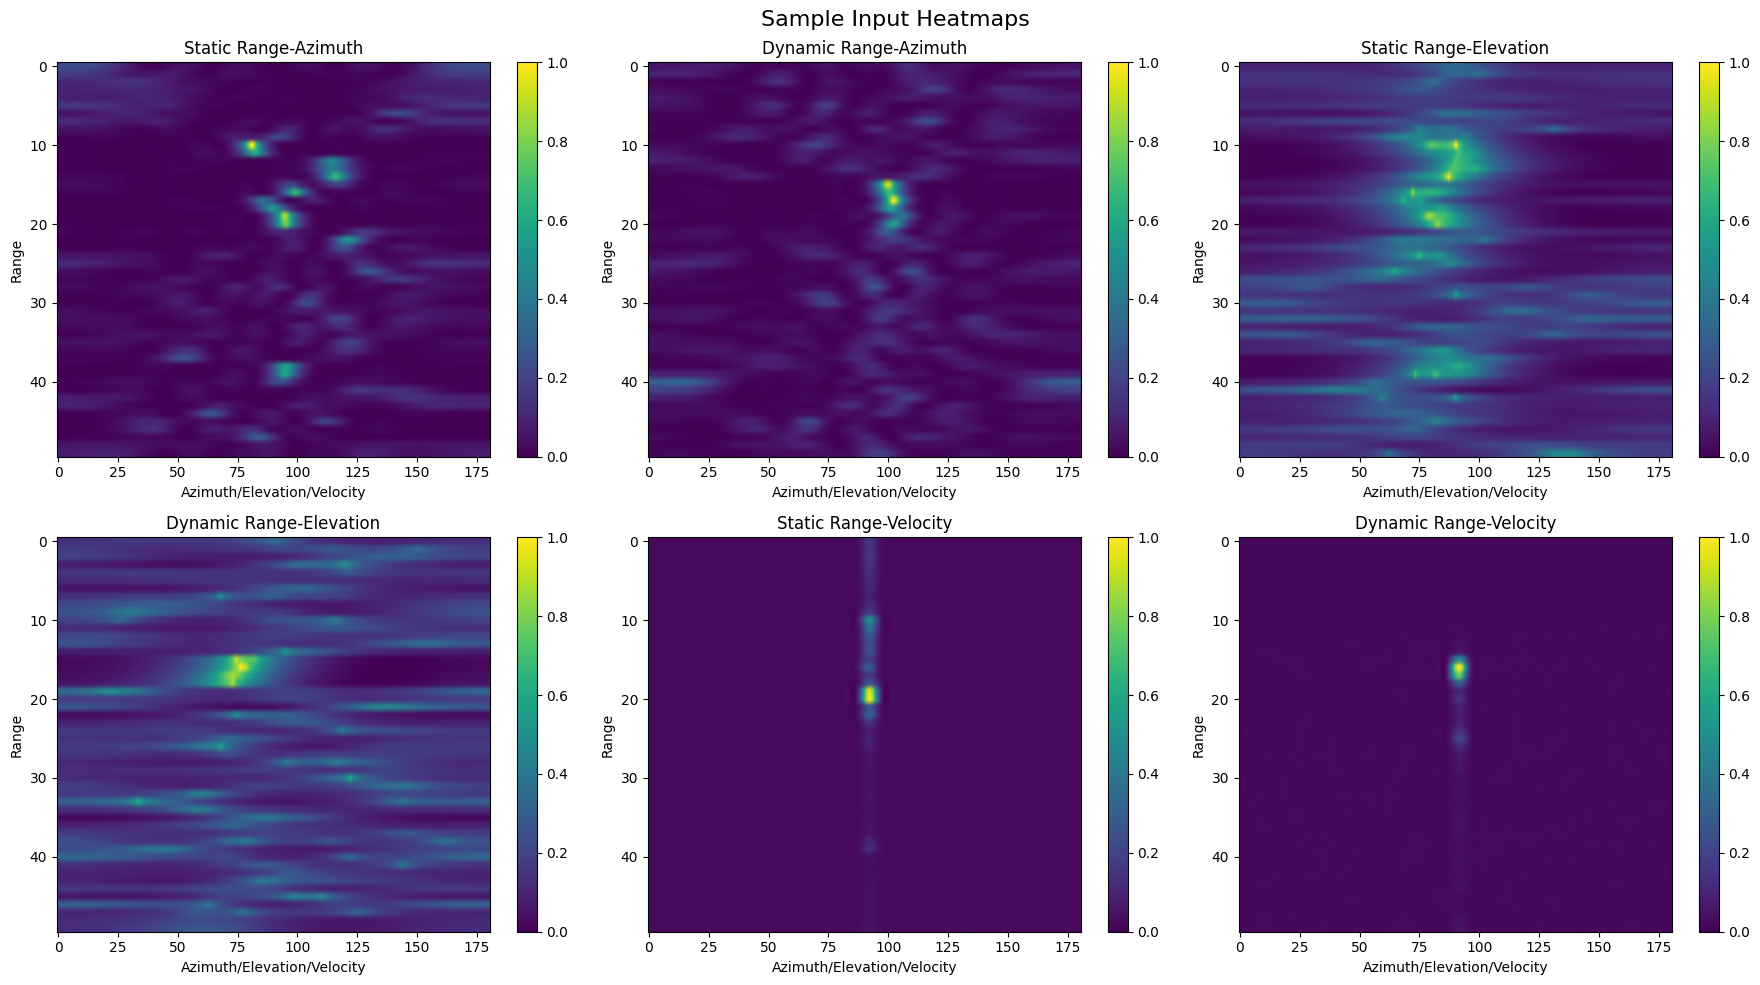

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Sample Input Heatmaps', fontsize=16, y=0.98)

heatmap_names = [
    'Static Range-Azimuth',
    'Dynamic Range-Azimuth',
    'Static Range-Elevation',
    'Dynamic Range-Elevation',
    'Static Range-Velocity',
    'Dynamic Range-Velocity'
]

# Plot all 6 input heatmaps
for i in range(6):
    ax = axes[i // 3, i % 3]
    im = ax.imshow(sample_data[i].numpy(), aspect='auto', cmap='viridis')
    ax.set_title(heatmap_names[i])
    ax.set_xlabel('Azimuth/Elevation/Velocity')
    ax.set_ylabel('Range')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

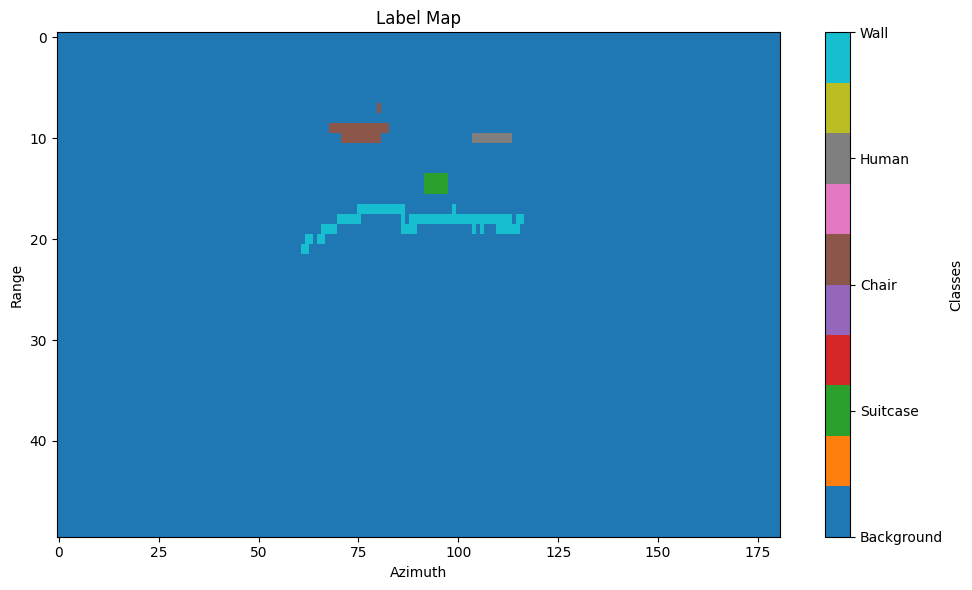

In [4]:
# Visualize label map separately
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
im = ax.imshow(sample_data[6].numpy(), aspect='auto', cmap='tab10', vmin=-1, vmax=3)
ax.set_title('Label Map')
ax.set_xlabel('Azimuth')
ax.set_ylabel('Range')
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1, 2, 3])
cbar.set_label('Classes')
cbar.ax.set_yticklabels(['Background', 'Suitcase', 'Chair', 'Human', 'Wall'])

plt.tight_layout()
plt.show()

The problem type is semantic segmentation.

## Spatial Distribution Analysis

The following analysis shows the spatial distribution of each class across all samples.





Analyzing spatial distribution of each class...


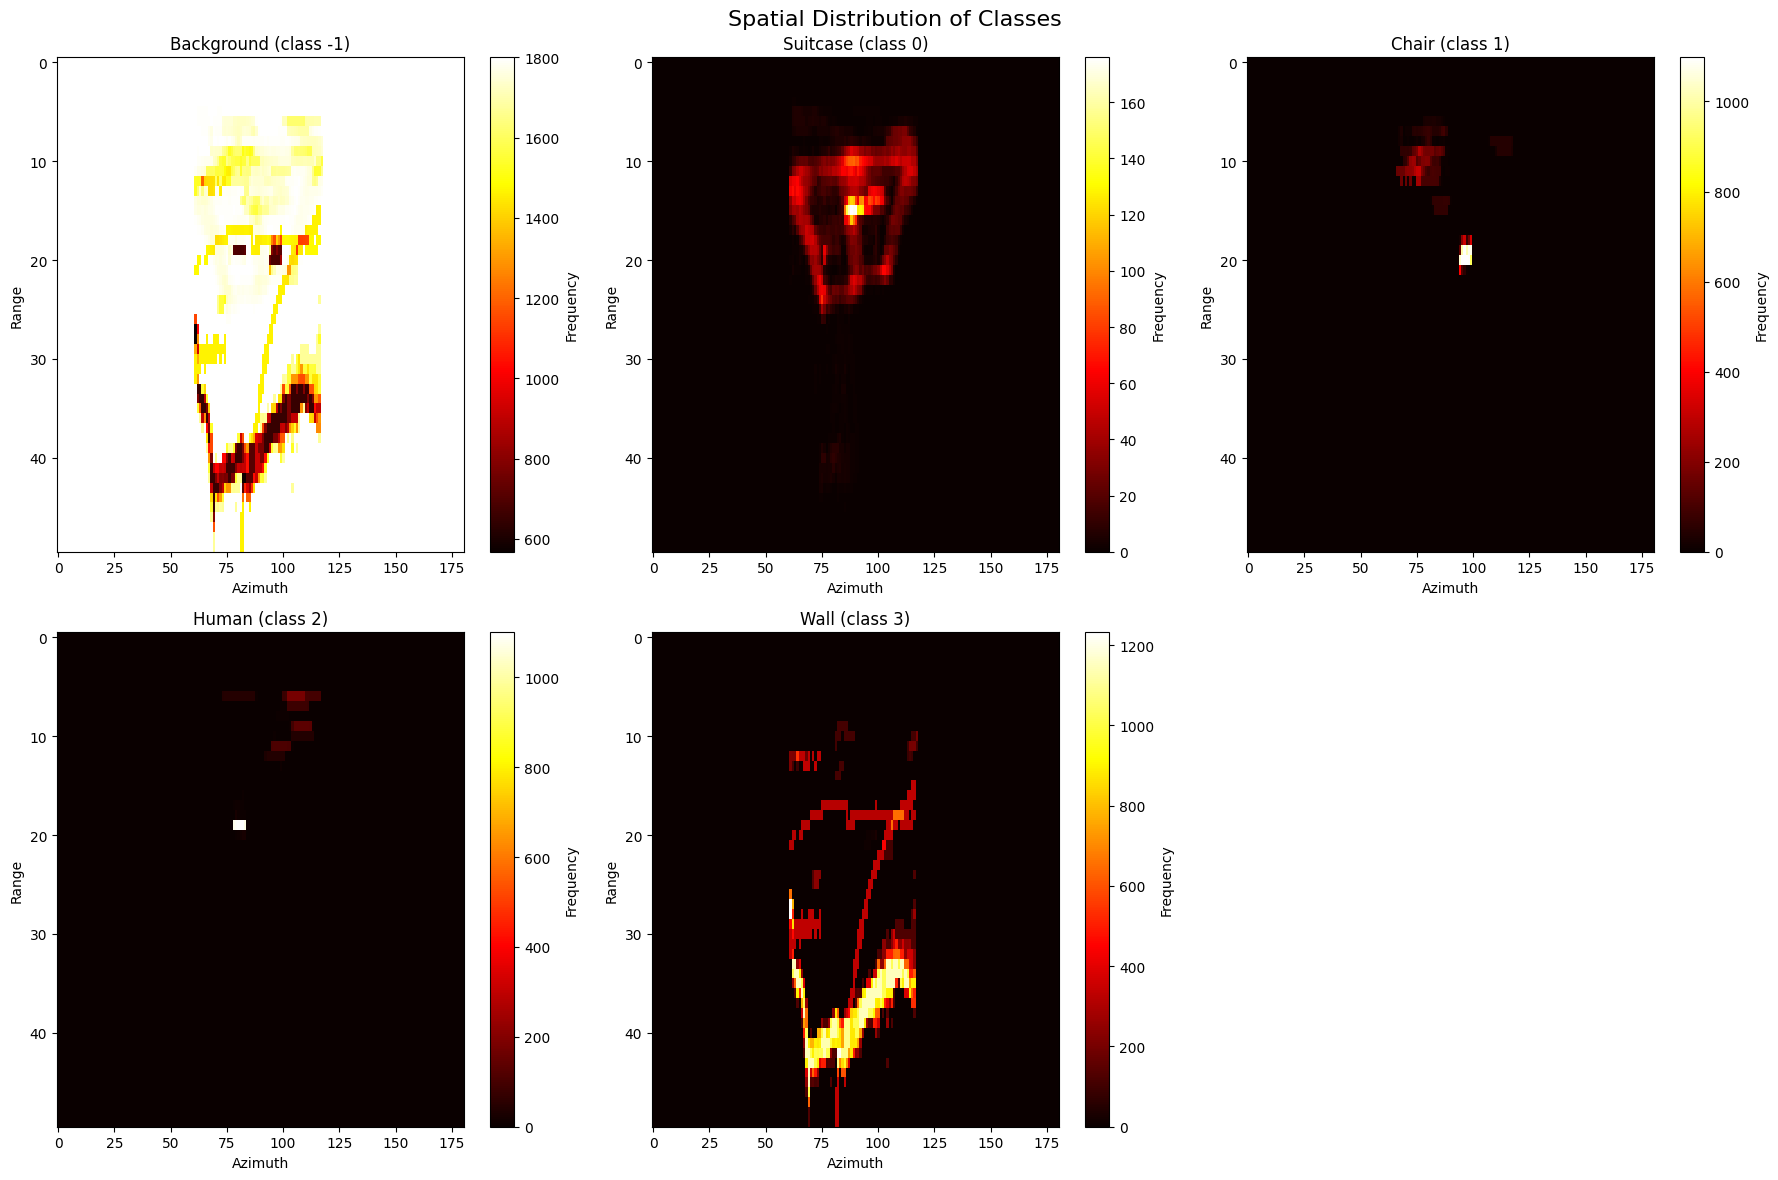

In [5]:
print("Analyzing spatial distribution of each class...")

class_names = {-1: 'Background', 0: 'Suitcase', 1: 'Chair', 2: 'Human', 3: 'Wall'}
spatial_distributions = {cls: np.zeros((50, 181)) for cls in class_names.keys()}

# Accumulate positions where each class appears
for file_path in file_paths:
    data = torch.load(file_path, weights_only=True)
    labels = data[6].numpy()
    
    for cls in class_names.keys():
        mask = (labels == cls).astype(float)
        spatial_distributions[cls] += mask

# Visualize object distribution heatmaps
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Spatial Distribution of Classes', fontsize=16)

for idx, (cls, name) in enumerate(class_names.items()):
    if idx < 5:  # Only 5 classes
        ax = axes[idx // 3, idx % 3]
        im = ax.imshow(spatial_distributions[cls], aspect='auto', cmap='hot', interpolation='nearest')
        ax.set_title(f'{name} (class {cls})')
        ax.set_xlabel('Azimuth')
        ax.set_ylabel('Range')
        plt.colorbar(im, ax=ax, label='Frequency')

# Hide empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Spatial Patterns

Based on the spatial distribution analysis:
1. **Walls**: Typically appear at the boundaries of the scene, forming the structure of the indoor environment. The wall class shows patterns along the edges and corners of the spatial grid, often forming L-shapes or continuous boundaries.
2. **Humans**: Tend to appear in the central regions of the scene, away from walls. The spatial distribution shows human presence is more concentrated in the middle range distances and central azimuth angles.
3. **Suitcases and Chairs**: These objects appear scattered throughout the scene but are more common in the mid-range distances. They show less predictable spatial patterns compared to walls, reflecting their varied placement in indoor environments.
4. **Background**: Dominates most of the spatial grid, particularly in areas with no objects or at far ranges where radar signal is weak.

## Wall Class Characteristics

The wall class shows relatively **continuous patterns** in most samples, forming coherent boundaries rather than fragmented segments. Walls typically appear as:
- Vertical boundaries (left/right edges in azimuth)
- Horizontal boundaries (near/far ranges)
- Corner structures (L-shapes where two walls meet)

This continuity is beneficial for segmentation as it provides structural context, though the walls may have varying thickness and clarity depending on radar signal strength.

## Relationships Between Static and Dynamic Heatmaps

Comparing static and dynamic heatmaps (indices 0-1 for range-azimuth, 2-3 for range-elevation, 4-5 for range-velocity):

1. **Static heatmaps** show stronger signals for stationary objects (walls, furniture)
2. **Dynamic heatmaps** highlight moving objects (humans, if in motion)
3. The complementary nature of static/dynamic pairs provides rich information for distinguishing between stationary structures and potentially moving objects
4. Velocity heatmaps (indices 4-5) add another dimension for detecting motion

## Analysis of Label Distribution


Label Distribution:
  Class -1 (Background): 15,907,597 pixels (97.65%)
  Class 0 (Suitcase): 23,233 pixels (0.14%)
  Class 1 (Chair): 27,585 pixels (0.17%)
  Class 2 (Human): 13,702 pixels (0.08%)
  Class 3 (Wall): 317,883 pixels (1.95%)

Total pixels: 16,290,000
Background percentage: 97.65%


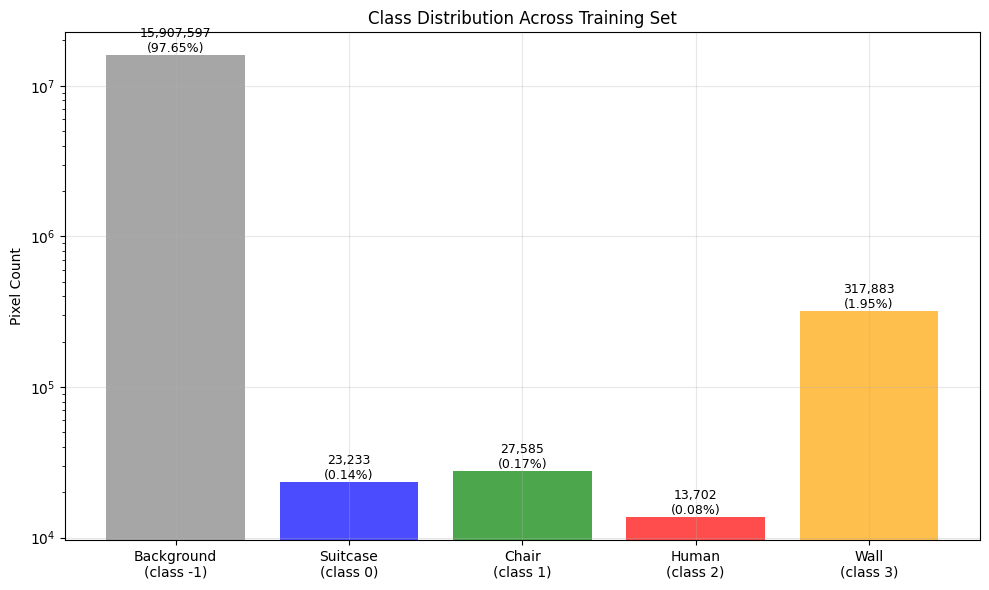

In [6]:
all_labels = []
for file_path in file_paths:
    data = torch.load(file_path, weights_only=True)
    labels = data[6].numpy().flatten()
    all_labels.extend(labels.tolist())

# Count occurrences of each class
label_counts = Counter(all_labels)
class_distribution = {cls: label_counts[cls] for cls in [-1, 0, 1, 2, 3]}

# Calculate total pixels and label distribution percentages
total_pixels = sum(class_distribution.values())
label_distribution_percentages = {cls: (class_distribution[cls] / total_pixels) * 100 for cls in [-1, 0, 1, 2, 3]}
background_percentage = label_distribution_percentages[-1]

print(f"\nLabel Distribution:")
for cls in [-1, 0, 1, 2, 3]:
    count = class_distribution[cls]
    pct = label_distribution_percentages[cls]
    print(f"  Class {cls} ({class_names[cls]}): {count:,} pixels ({pct:.2f}%)")

print(f"\nTotal pixels: {total_pixels:,}")
print(f"Background percentage: {background_percentage:.2f}%")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(10, 6))
classes = list(class_distribution.keys())
counts = list(class_distribution.values())
colors = ['gray', 'blue', 'green', 'red', 'orange']

bars = ax.bar(range(len(classes)), counts, color=colors, alpha=0.7)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels([f'{class_names[cls]}\n(class {cls})' for cls in classes])
ax.set_ylabel('Pixel Count')
ax.set_title('Class Distribution Across Training Set')
ax.set_yscale('log')  # Log scale due to severe imbalance
ax.grid(True, alpha=0.3)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/total_pixels*100:.2f}%)',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Training Challenges

This dataset presents several challenges for model training:

1. **Severe Class Imbalance**: With background representing >97% of pixels, models may be biased toward predicting background, resulting in poor performance on minority classes.

2. **Small Object Classes**: Suitcases, chairs, and humans each represent <1% of total pixels, making them difficult to learn without specific strategies (e.g., weighted loss functions, data augmentation).

3. **Multi-Modal Input**: The model needs to effectively leverage 6 different heatmap types simultaneously, requiring an architecture that can fuse multi-scale and multi-modal information.

4. **Spatial Resolution**: With dimensions of 50x181 pixels, the model needs to preserve fine-grained details while capturing global context.

5. **Class Similarity**: Some objects may have similar radar signatures, making classification challenging based on signal strength alone.

## Recommendations

To address these challenges:
- Use weighted loss functions or focal loss to handle class imbalance
- Consider data augmentation techniques suitable for radar data
- Design architectures with multi-branch or attention mechanisms to process different heatmap types
- Implement evaluation metrics that account for class imbalance (e.g., per-class accuracy, F1-scores)